In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler
import numpy as np

os.chdir("/Users/satya/Documents/sklearn-bax/")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace
from src.acquisition import run_acquisition
from src.algorithms import MultiRegionSetUnion, MultiRegionSetIntersection, GlobalOptimization1D, ParetoFront, Wishlist, PercentileSet
from src.models import MGPR, fit_hypers
from src.metrics import get_n_obtained, get_jaccard_posterior
from src.plotting import plot_final_metrics, plot_iteration_results
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


In [2]:
# X, Y = XY_from_csv("datasets/ssrl_ternary.csv", columns_x=["c_Fe", "c_Co"], columns_y=["coer", "kerr"])
X, Y = XY_from_csv("datasets/np_synthesis.csv", columns_x=["c1", "c2", "pH", "T"], columns_y=["size", "dispersity"])

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# x_scaler.fit([0, 30])
# y_scaler.fit([[0, 30]])

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

n_features = X.shape[1]
n_properties = Y.shape[1]

# handles one-property measurements
if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

In [3]:
algorithm = MultiRegionSetIntersection(threshold_list = [[0.0, 30.0], [0.0, 5]], scalers = scalers)
# algorithm = Wishlist(
#     threshold_bounds=[[[0.0, 2.0], [0.0, 0.2]], [[3.0, 4.0], [0.3, 0.4]], [[8.0, 10.0], [0.0, 0.1]]], scalers=scalers
# )

# algorithm = PercentileSet(percentile_threshold=95, scalers=scalers)
# algorithm = ParetoFront(tolerance_list = [1.0, 1.0],  max_or_min_list = [0, 0], scalers = scalers)

In [4]:
all_ids = list(np.arange(0, len(X)))  # integer mapping design space
true_target_ids = algorithm.identify_subspace(
    x=X, y=Y
)  # ground truth set of design points which achieve experimental goal

In [71]:
kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]
) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')

kernel_initial_list = n_properties * [kernel_initial]

kernel_list = fit_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list, n_restarts_optimizer=1)
multi_gpr = MGPR(kernel_list=kernel_list)



In [26]:
multi_gpr.fit(X[idx], Y[idx])

posterior_mean, posterior_std = multi_gpr.predict(X)

predicted_target_ids_posterior_mean = algorithm.identify_subspace(
    x=X, y=posterior_mean
)  # gro

In [30]:
posterior_samples = multi_gpr.sample_y(X, n_samples=10)


(1997, 2, 10)

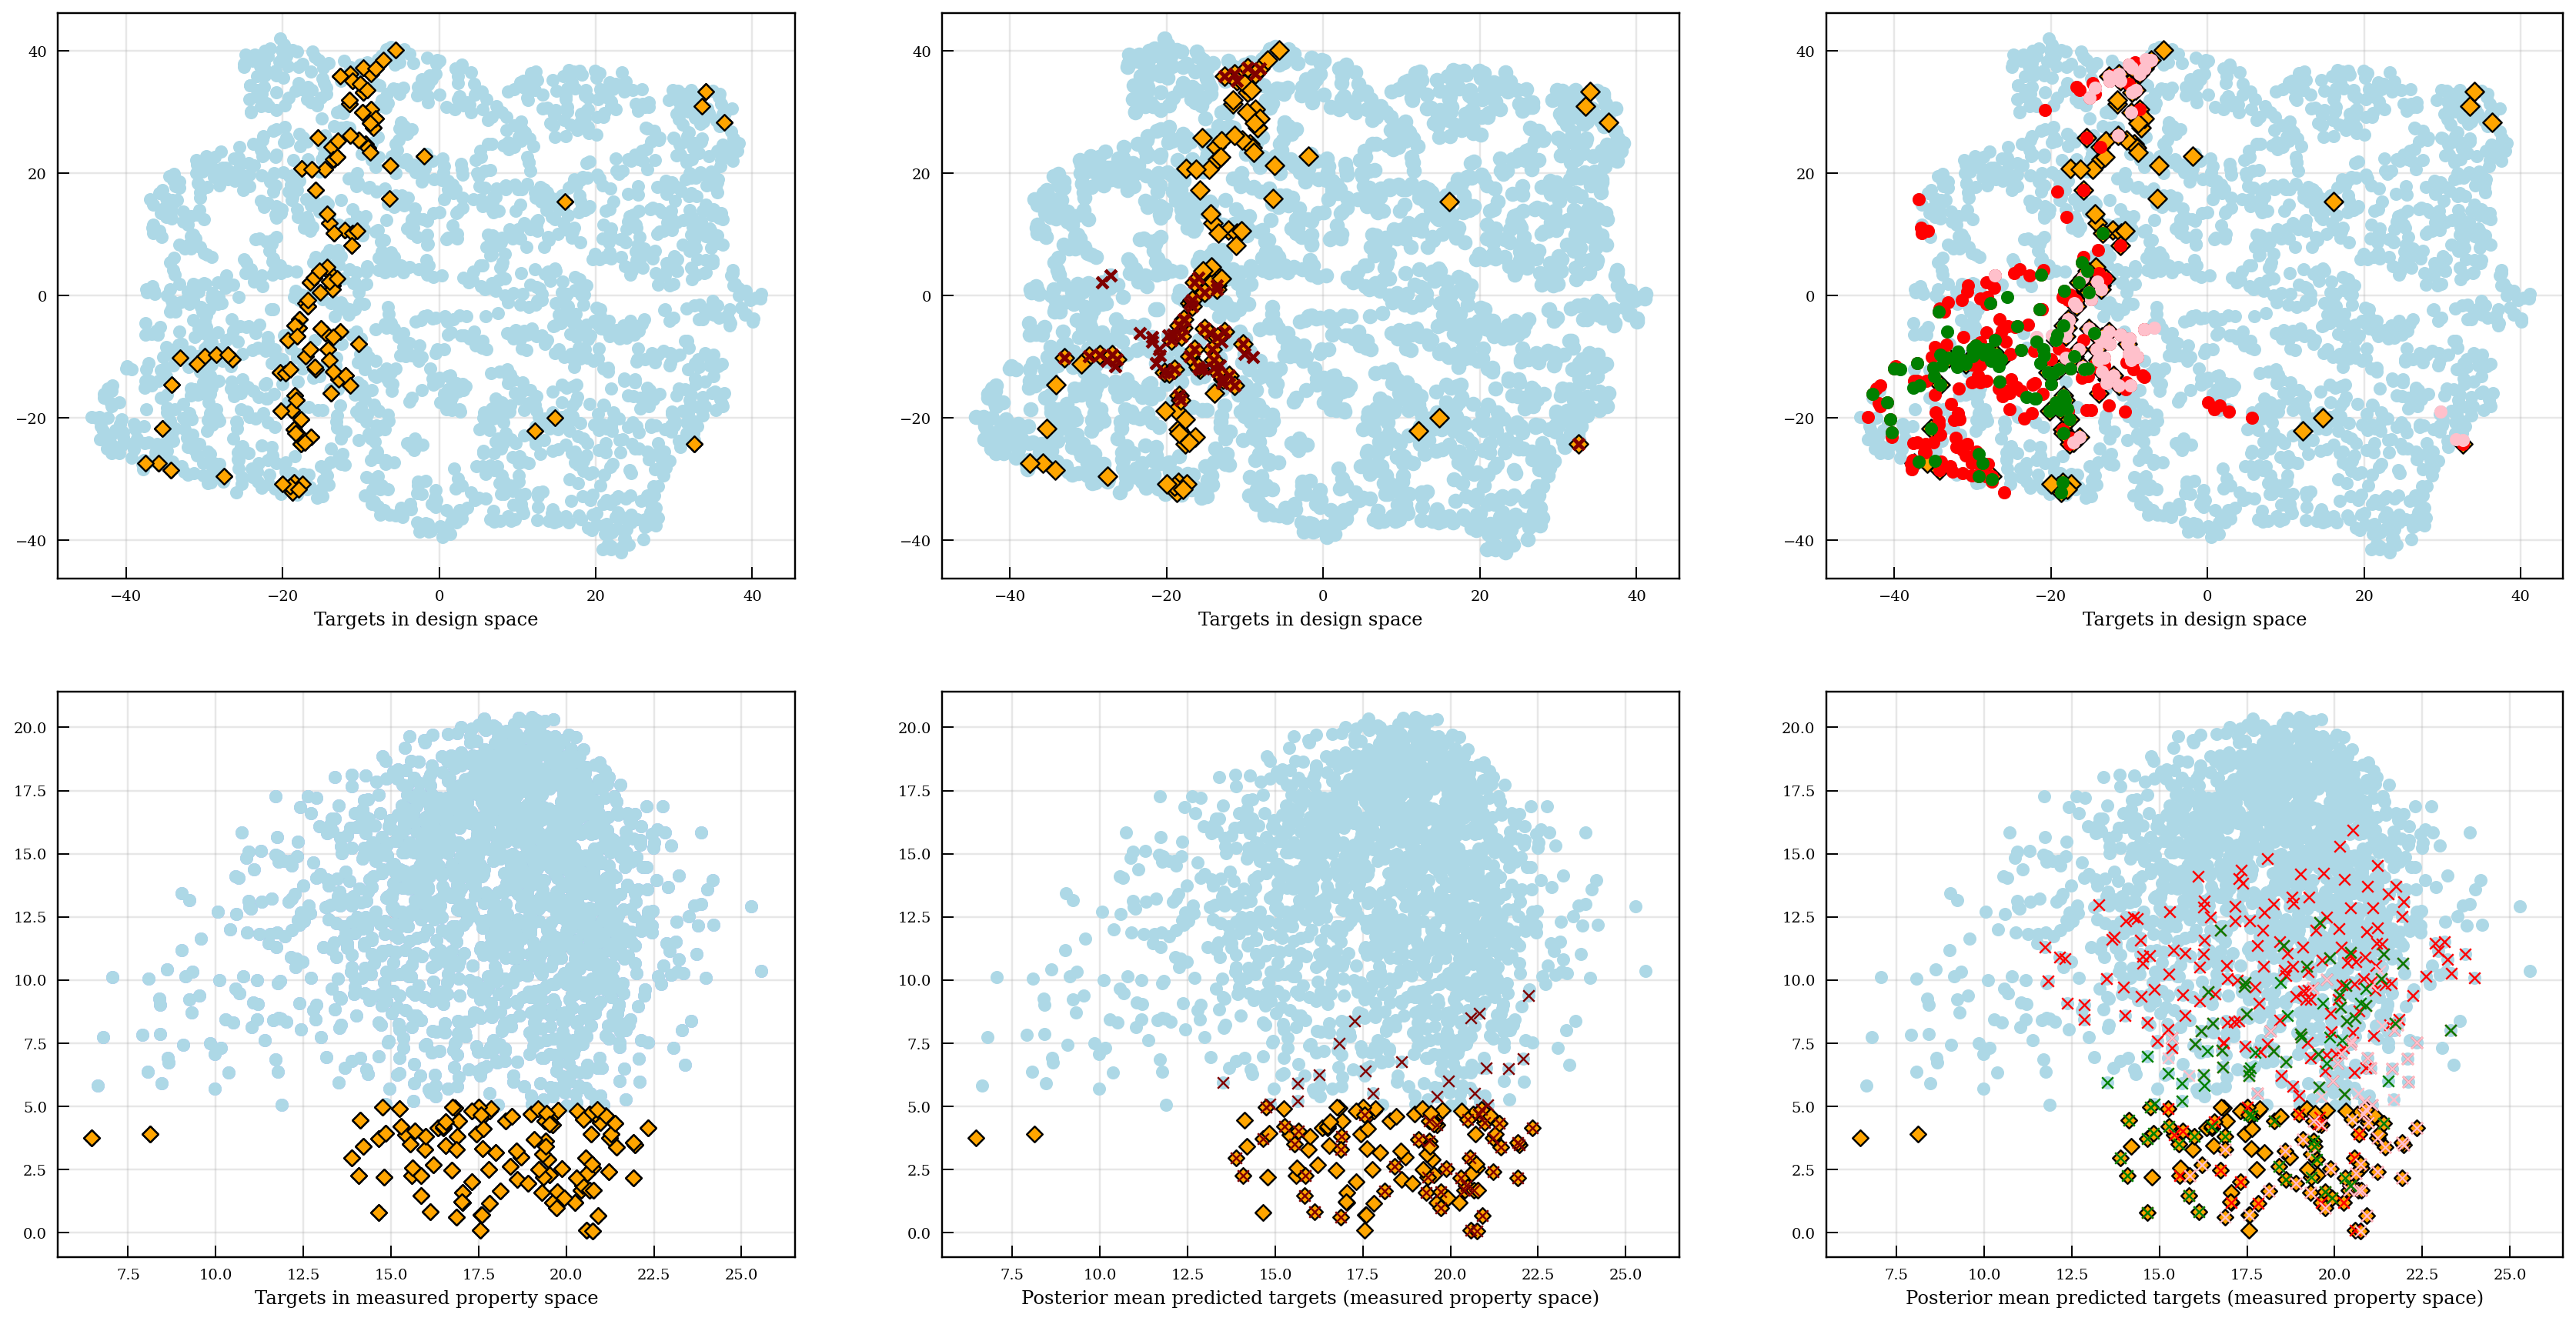

In [65]:
from sklearn.manifold import TSNE
X_unnorm = x_scaler.inverse_transform(X)
Y_unnorm = y_scaler.inverse_transform(Y)


if X_unnorm.shape[1] > 2:
    tsne = TSNE(n_components=2)
    X_unnorm = tsne.fit_transform(X_unnorm)


fig, axes = plt.subplots(2, 3, dpi=175, figsize=(24, 12))
X_unnorm = x_scaler.inverse_transform(X)

if X_unnorm.shape[1] > 2:
    tsne = TSNE(n_components=2)
    X_unnorm = tsne.fit_transform(X_unnorm)  #

axes[0, 0].scatter(
    X_unnorm[true_target_ids, 0], X_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)
axes[0, 0].set_xlabel("Targets in design space")

axes[0, 0].scatter(X_unnorm[:, 0], X_unnorm[:, 1], color="lightblue", alpha=1.0)
axes[0, 0].scatter(
    X_unnorm[true_target_ids, 0], X_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)


axes[0, 1].set_xlabel("Targets in design space")
axes[0, 1].scatter(X_unnorm[:, 0], X_unnorm[:, 1], color="lightblue", alpha=1.0, s = 50)
axes[0, 1].scatter(
    X_unnorm[true_target_ids, 0], X_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k", s = 50
)
axes[0, 1].scatter(
    X_unnorm[predicted_target_ids_posterior_mean, 0], X_unnorm[predicted_target_ids_posterior_mean, 1], color="maroon", marker="x", linewidths=2.0
)


axes[0, 2].set_xlabel("Targets in design space")
axes[0, 2].scatter(X_unnorm[:, 0], X_unnorm[:, 1], color="lightblue", alpha=1.0)
axes[0, 2].scatter(
    X_unnorm[true_target_ids, 0], X_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k", s=50
)

colors = ['red', 'pink', 'green']
for i in range(3):
    predicted_target_ids_posterior_sample = algorithm.identify_subspace(
    x=X, y=posterior_samples[:,:,i]
    )  # 
    axes[0, 2].scatter(
        X_unnorm[predicted_target_ids_posterior_sample, 0], X_unnorm[predicted_target_ids_posterior_sample, 1], color=colors[i], marker="o",
    )


axes[1, 0].scatter(Y_unnorm[:, 0], Y_unnorm[:, 1], color="blue", alpha=0.3)
axes[1, 0].scatter(
    Y_unnorm[true_target_ids, 0], Y_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)
axes[1, 0].set_xlabel("Targets in measured property space")

axes[1, 0].scatter(Y_unnorm[:, 0], Y_unnorm[:, 1], color="lightblue", alpha=1.0)
axes[1, 0].scatter(
    Y_unnorm[true_target_ids, 0], Y_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)

axes[1, 1].scatter(Y_unnorm[:, 0], Y_unnorm[:, 1], color="lightblue", alpha=1.0)
axes[1, 1].scatter(
    Y_unnorm[true_target_ids, 0], Y_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)
axes[1, 1].scatter(
    Y_unnorm[predicted_target_ids_posterior_mean, 0], Y_unnorm[predicted_target_ids_posterior_mean, 1], color="maroon", marker="x"
)
axes[1, 1].set_xlabel("Posterior mean predicted targets (measured property space)")


axes[1, 2].scatter(Y_unnorm[:, 0], Y_unnorm[:, 1], color="lightblue", alpha=1.0)
axes[1, 2].scatter(
    Y_unnorm[true_target_ids, 0], Y_unnorm[true_target_ids, 1], color="orange", marker="D", edgecolor="k"
)
axes[1, 2].set_xlabel("Posterior mean predicted targets (measured property space)")

colors = ['red', 'pink', 'green']
for i in range(3):
    predicted_target_ids_posterior_sample = algorithm.identify_subspace(
        x=X, y=posterior_samples[:,:,i]
    )  # 

    axes[1, 2].scatter(
        Y_unnorm[predicted_target_ids_posterior_sample, 0], Y_unnorm[predicted_target_ids_posterior_sample, 1], marker="x", color=colors[i]
    )



In [5]:
plotting = True
prevent_requery = True
plot_frequency = 100
n_posterior_samples = 15 # relevant for InfoBAX and mixedBAX 
n_initial = 1 # Number of initial datapoints 
n_iters = 101 # Number of measurements to be performed 
n_repeats = 1 # Repeats with different dataset initializations 
fixed_hypers = False 
adaptive_fit_freq = 10

kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]
) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')

kernel_initial_list = n_properties * [kernel_initial]

In [6]:

metrics = {
    "mixed": {"n_obtained": [], "jaccard_posterior_index": []},
    "meanbax": {"n_obtained": [], "jaccard_posterior_index": []},
    "infobax": {"n_obtained": [], "jaccard_posterior_index": []},
}

# Baseling for random sampling without replacement (expectation of hypergeometric distribution)
random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

# Baseline for best possible acquisition (i.e. acquire a target point at each iteration; need an "oracle" to do this)
if n_iters <= len(true_target_ids):
    best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
else:
    best_possible_n_obtained = list(np.arange(n_initial, len(true_target_ids))) + list(
        len(true_target_ids) * np.ones(n_iters + n_initial - len(true_target_ids))
    )

# Acquisition functions that use BAX for subset estimation
strategies = ["meanbax", "mixed", "infobax"]

# Calculate hypers based on the entire dataset; this is not possible in a real experiment but allows us to compare acquisition fn to acquisition fn
if fixed_hypers:
    kernel_list = fit_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list, n_restarts_optimizer=1)

for strategy in strategies:
    for j in range(n_repeats):  # to see variance w.r.t initial datapoint choice
        np.random.seed(j+1) # make sure all strategies get same initial points
        train_indices = list(np.random.choice(all_ids, n_initial))
        x_train = X[train_indices]
        y_train = Y[train_indices]

        collected_ids = list(train_indices)
        n_obtained_list = []
        jaccard_posterior_list = []

        for i in tqdm(range(n_iters)):
            # Adaptive hyperparameter fitting
            if (i % adaptive_fit_freq == 0) and (fixed_hypers == False):
                kernel_list = fit_hypers(x_train=x_train, y_train=y_train, kernel_list=kernel_initial_list)
            
            # Define GP model with fixed, fitted hypers. Note, we need this so that all the n_posterior models for InfoBAX have the same kernel
            multi_gpr = MGPR(kernel_list=kernel_list)

            # Acquire next index
            x_train, y_train, model, collected_ids, acquisition_function = run_acquisition(
                x_train, y_train, X, Y, strategy, algorithm, multi_gpr, collected_ids, n_posterior_samples
            )

            # Calculate metrics
            posterior_mean, posterior_std = model.predict(X)
            predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)
            n_obtained_list.append(get_n_obtained(collected_ids, true_target_ids))
            jaccard_posterior_list.append(get_jaccard_posterior(predicted_target_ids, true_target_ids))

            if (i % plot_frequency == 0) and (plotting) and (i != 0):
                plot_iteration_results(
                    X,
                    Y,
                    x_scaler,
                    y_scaler,
                    collected_ids,
                    true_target_ids,
                    predicted_target_ids,
                    acquisition_function,
                    n_obtained_list,
                    jaccard_posterior_list,
                    best_possible_n_obtained,
                    random_sampling,
                )

        metrics[strategy]["n_obtained"].append(n_obtained_list)
        metrics[strategy]["jaccard_posterior_index"].append(jaccard_posterior_list)

plot_final_metrics(n_iters, metrics, strategies, best_possible_n_obtained, random_sampling)

  1%|          | 1/101 [00:00<00:29,  3.42it/s]

[0.29**2 * Matern(length_scale=[0.461, 0.105, 0.0309, 0.0522], nu=2.5) + WhiteKernel(noise_level=0.01), 0.1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.01)]


 19%|█▉        | 19/101 [00:02<00:07, 10.34it/s]

[0.327**2 * Matern(length_scale=[3, 1.25, 1.05, 1.41], nu=2.5) + WhiteKernel(noise_level=0.01), 0.465**2 * Matern(length_scale=[0.978, 0.819, 1.34, 3], nu=2.5) + WhiteKernel(noise_level=0.01)]


 30%|██▉       | 30/101 [00:03<00:08,  8.70it/s]

[0.43**2 * Matern(length_scale=[1.44, 0.846, 0.781, 0.493], nu=2.5) + WhiteKernel(noise_level=0.01), 0.499**2 * Matern(length_scale=[1.11, 0.189, 0.606, 3], nu=2.5) + WhiteKernel(noise_level=0.01)]


 40%|███▉      | 40/101 [00:05<00:08,  7.36it/s]

[0.714**2 * Matern(length_scale=[2.71, 1.26, 1.36, 0.848], nu=2.5) + WhiteKernel(noise_level=0.01), 1.63**2 * Matern(length_scale=[3, 1.26, 1.24, 1.88], nu=2.5) + WhiteKernel(noise_level=0.01)]


 49%|████▊     | 49/101 [00:07<00:08,  6.31it/s]

[0.832**2 * Matern(length_scale=[3, 1.52, 1.53, 0.98], nu=2.5) + WhiteKernel(noise_level=0.01), 1.71**2 * Matern(length_scale=[3, 1.39, 1.36, 2.03], nu=2.5) + WhiteKernel(noise_level=0.01)]


 57%|█████▋    | 58/101 [00:09<00:07,  5.95it/s]

[0.956**2 * Matern(length_scale=[3, 1.71, 1.65, 1.11], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.44, 1.4, 2.1], nu=2.5) + WhiteKernel(noise_level=0.01)]


 64%|██████▍   | 65/101 [00:12<00:07,  4.51it/s]

[1.08**2 * Matern(length_scale=[3, 1.84, 1.84, 1.24], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.46, 1.42, 2.12], nu=2.5) + WhiteKernel(noise_level=0.01)]


 74%|███████▍  | 75/101 [00:15<00:06,  3.81it/s]

[1.13**2 * Matern(length_scale=[3, 1.91, 1.92, 1.29], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.48, 1.43, 2.15], nu=2.5) + WhiteKernel(noise_level=0.01)]


 83%|████████▎ | 84/101 [00:18<00:05,  3.26it/s]

[1.23**2 * Matern(length_scale=[3, 1.99, 2.04, 1.37], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.49, 1.44, 2.17], nu=2.5) + WhiteKernel(noise_level=0.01)]


 92%|█████████▏| 93/101 [00:21<00:03,  2.31it/s]

[1.25**2 * Matern(length_scale=[3, 2.02, 2.08, 1.4], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.5, 1.44, 2.19], nu=2.5) + WhiteKernel(noise_level=0.01)]


 98%|█████████▊| 99/101 [00:21<00:00,  4.21it/s]

[1.27**2 * Matern(length_scale=[3, 2.04, 2.11, 1.42], nu=2.5) + WhiteKernel(noise_level=0.01), 1.73**2 * Matern(length_scale=[3, 1.51, 1.45, 2.2], nu=2.5) + WhiteKernel(noise_level=0.01)]


In [ ]:
# plot_final_metrics(n_iters, metrics, strategies, best_possible_n_obtained, random_sampling)